In [1]:
# %matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import os
# Create a MirroredStrateg, If Multi-GPU available
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true' 
tf.config.set_soft_device_placement(True)
# strategy = tf.distribute.MirroredStrategy(devices=['/gpu:1','/gpu:2']) 
# print('Number of GPUs being used: {}'.format(strategy.num_replicas_in_sync))
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from livelossplot.keras import PlotLossesCallback
from livelossplot import PlotLossesKerasTF
import efficientnet.keras as efn
import h5py, glob, re, cv2, math, matplotlib
import tensorflow.keras as keras
import pandas as pd
from pandas import read_csv
import numpy as np
from scipy import stats
import itertools, random

# from cnn_utils import *
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from PIL import Image  
import pdb
from statistics import mode 
from IPython.display import clear_output

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

np.random.seed(1)
# Setting the seed for python random numbers
random.seed(1254)
# Setting the graph-level random seed.
tf.random.set_seed(89)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
!CUDA_VISIBLE_DEVICES=2

# strategy = tf.distribute.MirroredStrategy(devices=['/gpu:1','/gpu:2'])
# print('Number of GPUs being used: {}'.format(strategy.num_replicas_in_sync))
# print('Number of GPUs being used: {}'.format(strategy.num_replicas_in_sync))
# def setup_multi_node_training(): # IMPORTANT: SET UP TF_CONFIG FOR MULTINODE TRAINING HERE os.environ[“TF_FORCE_GPU_ALLOW_GROWTH”] = “true” tf.config.set_soft_device_placement(True) mirrored_strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy(tf.distribute.experimental.CollectiveCommunication.NCCL) # Constructs the configuration run_config = tf.estimator.RunConfig( train_distribute=mirrored_strategy, ) return run_config
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Using TensorFlow backend.


Num GPUs Available:  1


# Load Dataset - RD Map

In [2]:
sub = ['Emre','Mahbub','Sean','Charles']
sub

['Emre', 'Mahbub', 'Sean', 'Charles']

In [3]:
x_train1 = []
y_train1 = []
x_test1 = []
y_test1 = []
for i in range(0,len(sub)):
    filename = '../Radar Conference/Datasets/sequential/'+sub[i]+'_RDmap_128x128.hdf5'
    data = h5py.File(filename, "r")
    print('Selected File: '+str(filename))
    x_train1.append(np.array(data["train_img"]))
    y_train1.append(np.array(data["train_labels"]))
    x_test1.append(np.array(data["test_img"]))
    y_test1.append(np.array(data["test_labels"]))
    data.close()
x_train1 = np.concatenate(x_train1,axis=0)
y_train1 = np.concatenate(y_train1,axis=0)
x_test1 = np.concatenate(x_test1,axis=0)
y_test1 = np.concatenate(y_test1,axis=0)
print(x_train1.shape)
print(y_train1.shape)
print(x_test1.shape)
print(y_test1.shape)
y_train1bin = to_categorical(np.argmax(y_train1,-1)!=0) # binary
y_test1bin = to_categorical(np.argmax(y_test1,-1)!=0) # binary
print(y_train1bin.shape)
print(y_test1bin.shape)

Selected File: ../Radar Conference/Datasets/sequential/Emre_RDmap_128x128.hdf5
Selected File: ../Radar Conference/Datasets/sequential/Mahbub_RDmap_128x128.hdf5
Selected File: ../Radar Conference/Datasets/sequential/Sean_RDmap_128x128.hdf5
Selected File: ../Radar Conference/Datasets/sequential/Charles_RDmap_128x128.hdf5
(154, 750, 128, 128, 3)
(154, 750, 10)
(41, 750, 128, 128, 3)
(41, 750, 10)
(154, 750, 2)
(41, 750, 2)


In [4]:
# windowed
win = 0.2 # sec
y_train1win, cnt = stats.mode(np.argmax(y_train1,-1).reshape(y_train1.shape[0],int(y_train1.shape[1]*win),-1),2)
y_train1win  = to_categorical(np.squeeze(y_train1win))
y_test1win, cnt = stats.mode(np.argmax(y_test1,-1).reshape(y_test1.shape[0],int(y_test1.shape[1]*win),-1),2)
y_test1win  = to_categorical(np.squeeze(y_test1win))
y_train1winbin = to_categorical(np.argmax(y_train1win,-1)!=0)
y_test1winbin = to_categorical(np.argmax(y_test1win,-1)!=0)
print(y_train1win.shape)
print(y_test1win.shape)
print(y_train1winbin.shape)
print(y_test1winbin.shape)
x_train1win = x_train1.reshape(x_train1.shape[0],int(x_train1.shape[1]*win),-1,x_train1.shape[2],x_train1.shape[3],
                             x_train1.shape[4])
x_test1win = x_test1.reshape(x_test1.shape[0],int(x_test1.shape[1]*win),-1,x_test1.shape[2],x_test1.shape[3],
                             x_test1.shape[4])
print(x_train1win.shape)
print(x_test1win.shape)

(154, 150, 10)
(41, 150, 10)
(154, 150, 2)
(41, 150, 2)
(154, 150, 5, 128, 128, 3)
(41, 150, 5, 128, 128, 3)


In [5]:
# Range-weighted Energy
def RWE(video): # video is a no array
    rwe_vec = []
    frames = video.shape[0]
    height = video.shape[2]
    width = video.shape[1]
    
    x = np.zeros(shape=video.shape)
    for rangeBin in range(0,height):
        x[:,rangeBin,:,:] = 1/(rangeBin+np.finfo(float).eps) * video[:,rangeBin,:,:] 
    rwe_vec = np.sum(x,axis=(1,2,3))   
        
    return rwe_vec

In [6]:
# generate RWE plots and detect peak points with CFAR
rwes_test = []
rwes_train = []
th_vec = []
th_idx = []
peaks = []
num_train = 20
num_guard = 10
rate_fa = 2e-1
for i in range(0,len(x_test1)):
    vec = RWE(x_test1[i,:,:,:,:]) # train for figs
    rwes_test.append(vec)
for i in range(0,len(x_train1)):
    vec = RWE(x_train1[i,:,:,:,:]) # train for figs
    rwes_train.append(vec)
#     peak_idx, threshvec, threshidx = detect_peaks_all(vec, num_train=num_train, num_guard=num_guard, 
#                                                        rate_fa=rate_fa) # 20 25 1e-1
#     peaks.append(peak_idx)
#     th_vec.append(threshvec)
#     th_idx.append(threshidx)

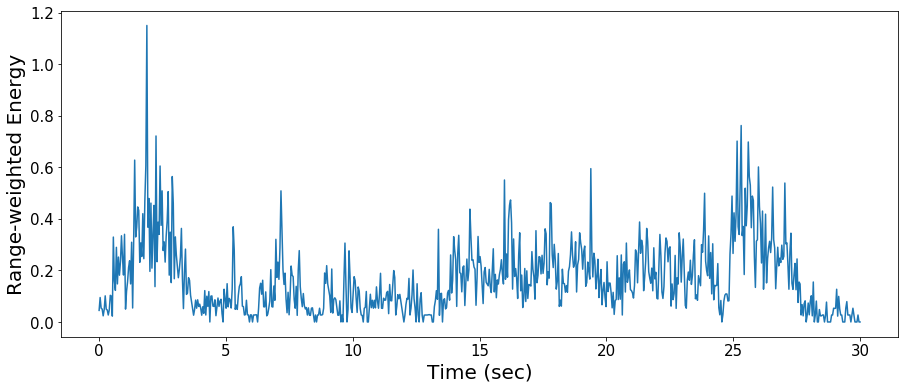

In [7]:
# No annotation sample
idx = 1
fps = 25
timevec = np.linspace(0,30,y_train1.shape[1])
matplotlib.rc('xtick',labelsize=15)
matplotlib.rc('ytick',labelsize=15)
p1,=plt.plot(timevec, rwes_test[idx])
plt.xlabel('Time (sec)',fontsize=20, weight='normal')
plt.ylabel('Range-weighted Energy',fontsize=20, weight='normal')
fig = plt.gcf()
fig.set_size_inches(15,6)
# plt.savefig('seq1 no annot.png')

### STA LTA

In [8]:
def sta_lta(vec,nsta,nlta,th_long,th_ratio,stepsz):
    
    vec2 = np.zeros(vec.shape)
    veclist = []
    mask = np.zeros(vec.shape)
    lastpnt = 0
    for i in range(0,len(vec)-nsta-nlta+1,stepsz):
        
        if i+nlta+nsta+1 > len(vec):
            break
            
        longwin = vec[i:i+nlta]
        shortwin = vec[i+nlta:i+nlta+nsta]
        
        if th_ratio > sum(shortwin)/sum(longwin) and np.mean(longwin) > th_long:
            for j in range(i+nlta,lastpnt,-stepsz):
                
                longwin_reverse = vec[j+nlta:j+2*nlta]
                shortwin_reverse = vec[j+nlta-nsta:j+nlta]
                
                if j+nlta-nsta < 0:
                    break
                if th_ratio > sum(shortwin_reverse)/sum(longwin_reverse):
                    vec2[j+nlta:i+nlta] = vec[j+nlta:i+nlta]
                    if len(vec2[j+nlta:i+nlta]) > 0:
                        veclist.append(vec2[j+nlta:i+nlta])
                    mask[j+nlta:i+nlta] = 1
                    lastpnt = i+nlta+nsta
                    break
    return vec2, veclist, mask

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in double_scalars


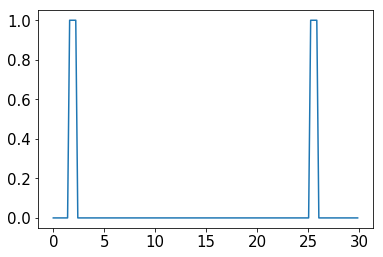

In [9]:
nsta = 15
nlta = 2*nsta
stepsz = 10
th_long = 0.3
th_ratio = 0.5
veclist = []
vecs = np.zeros(np.argmax(y_test1,-1).shape)
mask = np.zeros(np.argmax(y_test1,-1).shape)
for i in range(len(rwes_test)):
    vecs[i], vecsublist, mask[i] = sta_lta(rwes_test[i],nsta,nlta,th_long,th_ratio,stepsz)
    veclist.append(vecsublist)
mask_win = mask[:,::5]
mask_win.shape
plt.plot(timevec[::5],mask_win[idx])

In [10]:
def sta_lta2(vec,nlta,nsta,init_th,stop_th,stepsz):
    vec2 = np.zeros(vec.shape)
    mask = np.zeros(vec.shape)
    lastpnt = 0
    state = 0 # '0' nothing, '1' signing
    
    for i in range(0,len(vec)-nsta-nlta+1,stepsz):
        
        if i+nlta+nsta+1 > len(vec):
            break
            
        longwin = vec[i:i+nlta]
        shortwin = vec[i+nlta:i+nlta+nsta]
        
        if init_th < sum(shortwin)/sum(longwin):
            if state == 0:
                startpt = i+nlta
                state = 1
            if state == 1:
                continue
        
        else:
            if state == 0:
                continue
            if state == 1:
                if np.mean(shortwin) > stop_th:
                    continue
                else:
                    stoppt = i+nlta
                    state = 0
                    vec2[startpt:stoppt] = vec[startpt:stoppt]
                    mask[startpt:stoppt] = 1
                    
    return vec2, mask

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app


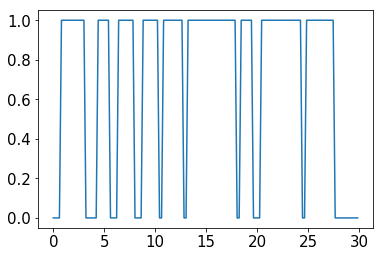

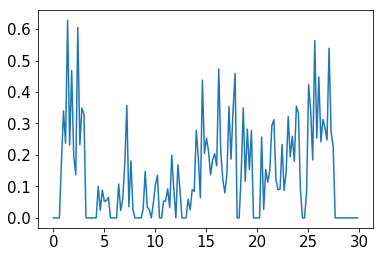

In [11]:
nsta = 10
nlta = 2*nsta
stepsz = 10
init_th = 0.3
stop_th = 0.5
vecs_train = np.zeros(np.argmax(y_train1,-1).shape)
mask_train = np.zeros(np.argmax(y_train1,-1).shape)
vecs_test = np.zeros(np.argmax(y_train1,-1).shape)
mask_test = np.zeros(np.argmax(y_test1,-1).shape)
for i in range(len(rwes_train)):
    vecs_train[i], mask_train[i] = sta_lta2(rwes_train[i],nlta,nsta,init_th,stop_th,stepsz)
mask_train_win = mask_train[:,::5]
for i in range(len(rwes_test)):
    vecs_test[i], mask_test[i] = sta_lta2(rwes_test[i],nlta,nsta,init_th,stop_th,stepsz)
mask_test_win = mask_test[:,::5]
plt.plot(timevec[::5],mask_test_win[idx])
plt.figure()
plt.plot(timevec[::5],vecs_test[idx][::5])

In [12]:
mask.shape

(41, 750)

In [13]:
x1train = []
y1train = []
flag = 0
for i in range(len(mask_train)):
    for j in range(mask_train.shape[1]):
        if mask_train[i,j] == 0:
            if flag == 0:
                continue
            else:
                stoppt = j
                x1train.append(x_train1[i,startpt:stoppt])
                y1train.append(np.squeeze(stats.mode(np.argmax(y_train1[i,startpt:stoppt],-1))[0]))
                flag = 0
        else:
            if flag == 0:
                startpt = j
                flag = 1
            else:
                continue
x1train = np.asarray(x1train)
y1train = to_categorical(np.array(y1train))
x1test = []
y1test = []
flag = 0
for i in range(len(mask_test)):
    for j in range(mask_test.shape[1]):
        if mask_test[i,j] == 0:
            if flag == 0:
                continue
            else:
                stoppt = j
                x1test.append(x_test1[i,startpt:stoppt])
                y1test.append(np.squeeze(stats.mode(np.argmax(y_test1[i,startpt:stoppt],-1))[0]))
                flag = 0
        else:
            if flag == 0:
                startpt = j
                flag = 1
            else:
                continue
x1test = np.asarray(x1test)
y1test = to_categorical(np.array(y1test))
print(x1train.shape)
print(y1train.shape)
print(x1test.shape)
print(y1test.shape)

(1407,)
(1407, 10)
(386,)
(386, 10)


In [14]:
from collections import Counter
print('# of samples in each class:')
counter = Counter(np.argmax(y1train, -1))
counter

# of samples in each class:


Counter({2: 150,
         7: 148,
         8: 148,
         9: 143,
         6: 134,
         5: 128,
         3: 159,
         0: 77,
         4: 153,
         1: 167})

In [15]:
def data_generator(data, labels, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data.shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
    #             print ('starting index: ', offset) 
            # Get the samples you'll use in this batch
            batch_samples = data[offset:offset+batch_size]
            label = labels[offset:offset+batch_size]
            # Initialise X_train and y_train arrays for this batch
            X_train = []
            y_train = []
            # For each example
            for i in range(0,batch_samples.shape[0]):
                X_train.append(batch_samples[i])
                y_train.append(label[i])

            # Make sure they're numpy arrays (as opposed to lists)
            X_train = np.array(X_train)
            #X_train = np.rollaxis(X_train,1,4)
            y_train = np.array(y_train)

            # yield the next training batch            
            yield X_train, y_train

# RD map Classification

In [16]:
epochs, batch_size, verbose, num_class = 20, 1, 1, y1test.shape[-1]
print('Num class: ',str(num_class))
input_shape1 = (None,x1train[0].shape[1],x1train[0].shape[2],x1train[0].shape[3])
print('Input shape of RD maps: ',input_shape1)

Num class:  10
Input shape of RD maps:  (None, 128, 128, 3)


In [17]:
train_generator = data_generator(x1train, y1train)
test_generator = data_generator(x1test, y1test)

In [62]:
train_dataset = tf.data.Dataset.from_tensor_slices((x1train, y1train))
train_dataset = (
    train_dataset.map(
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x1test, y1test))
validation_dataset = (
    validation_dataset.map(
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.ndarray).

In [20]:
def get_dataset(x_train,y_train,x_test,y_test): # recommended for multi-gpu
        return (
        tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size),
        tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size),
    )

### TD2D CNN + BiLSTM

In [53]:
def tdcnn2d_bilstm():
    with tf.device('/gpu:2'):
#     with strategy.scope():
        inputlayer1 = Input(shape = input_shape1)
        x = TimeDistributed(Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu'))(inputlayer1)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
#         x = TimeDistributed(Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu'))(x)
#         x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
        x = TimeDistributed(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
        x = TimeDistributed(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
        x = TimeDistributed(Flatten())(x)
#         mask = Masking(mask_value=0.)(x)
        x = Bidirectional(LSTM(128, dropout=0.5, return_sequences=False))(x)
        
        out1 = Dense(num_class,activation='softmax')(x)
#         out1 = TimeDistributed(Dense(num_class,activation='softmax'))(x, mask=maskinput)
#         model = keras.Model(inputs = [inputlayer1,maskinput], outputs = [out1])#, out2, out3])
        model = keras.Model(inputs = [inputlayer1], outputs = [out1])#, out2, out3])
        opt = Adam(lr=1e-3, decay=1e-3 / 200)
        model.compile(loss = 'categorical_crossentropy', optimizer=opt,metrics = ['accuracy'],sample_weight_mode="temporal")
        return model 

## 3D CNN + LSTM

In [54]:
def cnn3d_lstm():
    with tf.device('/gpu:2'):
#     with strategy.scope():
        inputlayer = Input(shape = input_shape1)
        x = Conv3D(8, kernel_size=(3, 3, 3), padding='same', activation='relu')(inputlayer)
        x = MaxPooling3D(pool_size=(1,2,2))(x)
        x = Conv3D(32, kernel_size=(3, 3, 3), padding='same', activation='relu')(x)
        x = MaxPooling3D(pool_size=(1,2,2))(x)
        x = Conv3D(64, kernel_size=(3, 3, 3), padding='same', activation='relu')(x)
        x = MaxPooling3D(pool_size=(1,2,2))(x)
    #     x = Conv3D(64, kernel_size=(3, 3, 3), padding='same', activation='relu')(x)
    #     x = MaxPooling3D(pool_size=(1,2,2))(x)
    #     x = TimeDistributed(Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu'))(inputlayer)
    #     x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
    #     x = TimeDistributed(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))(x)
    #     x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
    #     x = TimeDistributed(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))(x)
    #     x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
        x = TimeDistributed(Flatten())(x)
#         mask = Masking(mask_value=0.)(x)
        x = Bidirectional(LSTM(128, dropout=0.5, return_sequences=False))(x)
        out = Dense(num_class,activation='softmax')(x)
        model = keras.Model(inputs=inputlayer, outputs=[out]) # keras.Model
        opt = Adam(lr=1e-3, decay=1e-3 / 200)
        model.compile(loss = 'categorical_crossentropy', optimizer=opt,metrics = ['accuracy'])
        return model

### TimeDist(3D CNN) + BiLSTM

In [55]:
def tdcnn3d_bilstm():
    with tf.device('/gpu:2'):
#     with strategy.scope():
        inputlayer1 = Input(shape = input_shape1win)
#         maskinput = Input(shape=(None,),dtype='bool')
        x = TimeDistributed(Conv3D(8, kernel_size=(3, 3, 3), padding='same', activation='relu'))(inputlayer1)
        x = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(x)
        x = TimeDistributed(Conv3D(8, kernel_size=(3, 3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(x)
        x = TimeDistributed(Conv3D(16, kernel_size=(3, 3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(x)
        x = TimeDistributed(Conv3D(32, kernel_size=(3, 3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(x)
        x = TimeDistributed(Flatten())(x)
        
        x = Bidirectional(LSTM(64, dropout=0.5, return_sequences=True))(x)
        
        out1 = TimeDistributed(Dense(num_class,activation='softmax'))(x,)
        model = keras.Model(inputs = [inputlayer1], outputs = [out1])#, out2, out3])
#         out1 = TimeDistributed(Dense(num_class,activation='softmax'))(x,mask=maskinput)
#         model = keras.Model(inputs = [inputlayer1,maskinput], outputs = [out1])#, out2, out3])
        opt = Adam(lr=1e-3, decay=1e-3 / 200)
        model.compile(loss = 'categorical_crossentropy', optimizer=opt,metrics = ['accuracy'],sample_weight_mode="temporal")
        return model

## Create Model

In [56]:
def gen_temporal_class_w8(y):
    yw8 = np.concatenate(np.argmax(y,-1),0)
    yint = np.argmax(y,-1)
    uniqs = np.unique(yw8)
    class_weights = class_weight.compute_class_weight('balanced',uniqs,yw8)
    temp_w8 = np.zeros(yint.shape)
    for i in range(0,y.shape[-1]):
        temp_w8[yint==i] = class_weights[i]
    return temp_w8, class_weights

In [57]:
def get_dataset_tempw8(x_train,y_train,x_test,y_test,w8): # recommended for multi-gpu
        return (
        tf.data.Dataset.from_tensor_slices((x_train, y_train, w8)).batch(batch_size),
        tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size),
    )

In [58]:
model11 = tdcnn2d_bilstm()
model11.summary()
# temp_w8, class_weights = gen_temporal_class_w8(y_train1bin)
# mask_train = np.ones((x_train1win.shape[0],x_train1win.shape[1]))
# mask_test = np.ones((x_test1win.shape[0],x_test1win.shape[1]))
# train_gen11, test_gen11 = get_dataset_tempw8(x_train1,y_train1,x_test1,y_test1,temp_w8)
# train_gen11, test_gen11 = get_dataset_tempw8_mask(x_train1,y_train1,mask_train,x_test1,y_test1,mask_test,temp_w8)

# class_weights = {i : class_weights[i] for i in range(len(uniqs))}

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, None, 128, 128, 3 0         
_________________________________________________________________
time_distributed_23 (TimeDis (None, None, 128, 128, 8) 224       
_________________________________________________________________
time_distributed_24 (TimeDis (None, None, 64, 64, 8)   0         
_________________________________________________________________
time_distributed_25 (TimeDis (None, None, 64, 64, 16)  1168      
_________________________________________________________________
time_distributed_26 (TimeDis (None, None, 32, 32, 16)  0         
_________________________________________________________________
time_distributed_27 (TimeDis (None, None, 32, 32, 32)  4640      
_________________________________________________________________
time_distributed_28 (TimeDis (None, None, 16, 16, 32) 

### Train

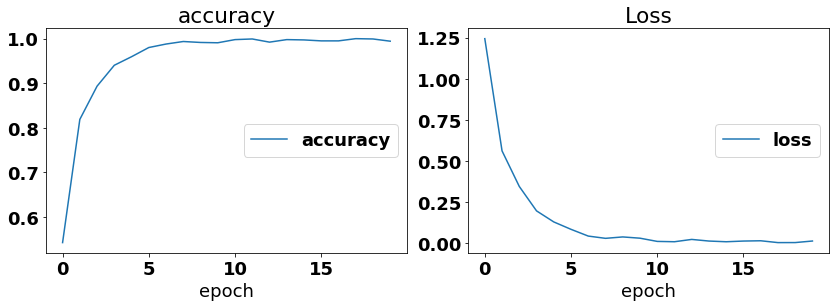

accuracy
	accuracy         	 (min:    0.000, max:    1.000, cur:    0.994)
Loss
	loss             	 (min:    0.000, max:    3.877, cur:    0.012)
1407/1407 [==============================] - 21s 15ms/step - loss: 0.0124 - accuracy: 0.9943


In [59]:
history = model11.fit(train_generator,# validation_data=test_generator,
                        epochs=epochs, batch_size=1, steps_per_epoch = len(x1train),
                        shuffle=False, callbacks = [PlotLossesKerasTF()], 
                        verbose=verbose)

<function matplotlib.pyplot.show(*args, **kw)>

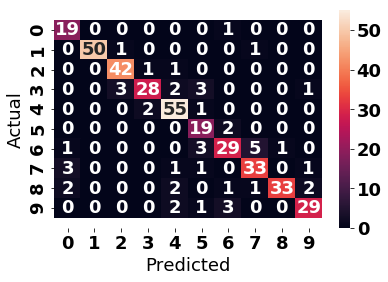

In [60]:
import pandas as pd
import seaborn as sn
# %matplotlib qt 
# opens figure in a new window
font = {'family' : 'normal', 
        'weight' : 'bold',
        'size'   : 18}

plt.rc('font', **font) 
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18) 
# predictions = model.predict(x_test,batch_size=1)
pred = np.zeros(y1test.shape)
for i in range(0,x1test.shape[0]):
    pred[i] = model11.predict(np.expand_dims(x1test[i], axis=0))
Y_pred = np.argmax(pred, axis=-1)
Y_test_int = np.argmax(y1test, axis=-1)
#print(predictions[0:5])
#print(Y_pred[0:5])
#print(Y_test_int[0:5])
data = {'y_Predicted': Y_pred,
        'y_Actual':    Y_test_int
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'], margins = False)
fig3 = plt.figure()
sn.heatmap(confusion_matrix, annot=True)
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b,t)
plt.show

In [61]:
cmp = Y_pred == Y_test_int
trues = np.sum(cmp)
acc = trues/len(cmp)*100
acc

87.30569948186529